In [1]:
#!jupyter nbconvert --to=python MZ_DIN_WOA_detailed_comparison_python3.ipynb

# After changes in the script using Jupyter notebook, save the notebook, run this line, and clear the output.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata
import skill_metrics as sm
import cartopy.crs as ccrs
import pickle

import pyfesom2 as pf


#import sys
#sys.path.append('home/ollie/mozeisin/')
#from PiecewiseNorm import PiecewiseNorm
#modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
#sys.path.append('/home/ollie/mozeisin/pyfesom2/pyfesom2/')


In [3]:
# cartopy specification -------------------------------------------------------------------------------------
#p_PC = ccrs.PlateCarree()
#p_Rb = ccrs.Robinson()

In [4]:
# run specification -------------------------------------------------------------------------------------
runname = 'mo1'
runid = runname
var = 'Dia'

resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runname
savepath = '/home/ollie/mozeisin/evaluation/mo_files'
htmlname     =  runname+'_DIN_WOA.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'
export_html = False

meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# period of analysis ------------------------------------------------------------------------------------

first_year = 1975
last_year  = 1984

In [5]:
# load FESOM mesh -------------------------------------------------------------------------------------
mesh       = pf.load_mesh(meshpath)
#print(mesh.zlev)

## World Ocean Atlas

In [6]:
# load WOA DIN -------------------------------------------------------------------------------------
ncfileDIN                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
#!ncdump -h $ncfileDIN

labelwoa = 'World Ocean Atlas DIN'
unitwoa = 'DIN [$\mu$mol L$^{-1}$]'

f          = Dataset(ncfileDIN, 'r')
DepthRaw   = -f.variables['depth'][:]                                
lonwoa     =  f.variables['lon'][:]
latwoa     =  f.variables['lat'][:]
Timewoa     =  f.variables['time'][:]
DINwoa     =  f.variables['n_an'][:]
DINwoa     = np.squeeze(DINwoa)
DINwoa     = np.ma.filled(DINwoa, np.nan)                            # From masked array to numpy array

X360, Y180 = np.meshgrid(lonwoa, latwoa)

print('WOA Shape DINwoa: {0} \nDepths n = {1} \nValues: {2}'.format(np.shape(DINwoa),len(DepthRaw),DepthRaw.view())) # depth, lat, lon

# compare to FESOM mesh
print('\nFESOM: \nDepths n = {0} \nValues: {1}'.format(len(mesh.zlev), mesh.zlev))

WOA Shape DINwoa: (102, 180, 360) 
Depths n = 102 
Values: [-0.0 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 -40.0 -45.0 -50.0 -55.0
 -60.0 -65.0 -70.0 -75.0 -80.0 -85.0 -90.0 -95.0 -100.0 -125.0 -150.0
 -175.0 -200.0 -225.0 -250.0 -275.0 -300.0 -325.0 -350.0 -375.0 -400.0
 -425.0 -450.0 -475.0 -500.0 -550.0 -600.0 -650.0 -700.0 -750.0 -800.0
 -850.0 -900.0 -950.0 -1000.0 -1050.0 -1100.0 -1150.0 -1200.0 -1250.0
 -1300.0 -1350.0 -1400.0 -1450.0 -1500.0 -1550.0 -1600.0 -1650.0 -1700.0
 -1750.0 -1800.0 -1850.0 -1900.0 -1950.0 -2000.0 -2100.0 -2200.0 -2300.0
 -2400.0 -2500.0 -2600.0 -2700.0 -2800.0 -2900.0 -3000.0 -3100.0 -3200.0
 -3300.0 -3400.0 -3500.0 -3600.0 -3700.0 -3800.0 -3900.0 -4000.0 -4100.0
 -4200.0 -4300.0 -4400.0 -4500.0 -4600.0 -4700.0 -4800.0 -4900.0 -5000.0
 -5100.0 -5200.0 -5300.0 -5400.0 -5500.0]

FESOM: 
Depths n = 48 
Values: [ 0.00e+00 -5.00e+00 -1.00e+01 -2.00e+01 -3.00e+01 -4.00e+01 -5.00e+01
 -6.00e+01 -7.00e+01 -8.00e+01 -9.00e+01 -1.00e+02 -1.15e+02 -1.35e+02
 -1.60e

<ipython-input-7-33ec5f6eff67>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(X360, Y180, DINwoa[0,:,:])#, transform = p_PC)


Text(0.5, 1.0, 'World Ocean Atlas DIN')

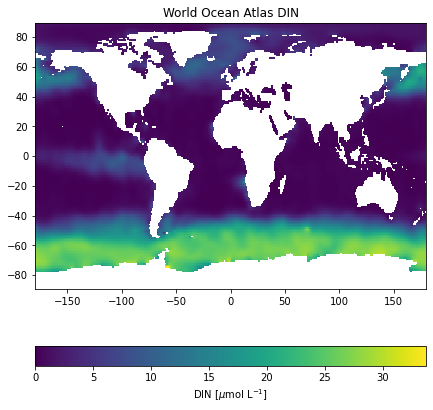

In [7]:
# first overview -----------------------------------------------------------------------------------
fig = plt.figure(figsize= (7,7))
ax = plt.subplot()#projection = p_Rb)
im = ax.pcolor(X360, Y180, DINwoa[0,:,:])#, transform = p_PC)
cbar = fig.colorbar(im, orientation = 'horizontal')
cbar.set_label(unitwoa) 
plt.title(labelwoa)


In [8]:
# interpolation specification ------------------------------------------------------------------------------------
use_pickle = False
pickle_file = 'TEMP_woa_din_interpolated'

if(use_pickle == False):
    # original py_recom code:
    #do2_int = np.zeros(len(mesh.z3))                                  # initializing target field for interpolation 
    #for k in range(0,len(mesh.zlevs)):

    # check maximum depth in WOA compared to FESOM
    dmin_woa = np.min(DepthRaw)
    dmin_fesom = np.min(mesh.zlev)

    if(dmin_woa <= dmin_fesom):
        print('***\nDepth greater in WOA ({0}) than in FESOM ({1})'.format(dmin_woa, dmin_fesom))
        ilev = len(mesh.zlev)
        max_zlev = mesh.zlev[ilev-1]
    else:
        print('***\nDepth greater in FESOM ({1}) than in WOA ({0})'.format(dmin_woa, dmin_fesom))
        ilev = np.where(mesh.zlev >= dmin_woa)
        ilev = ilev[0][-1]
        max_zlev = mesh.zlev[ilev]

    print('Please consider choosing max depth level {0} with max depth at {1}!\n***'.format(ilev,max_zlev))
    
    # storage container
    din_int = np.zeros((len(mesh.zlev)-1,len(mesh.x2)))
    #print(np.shape(din_int))
    
    for k in range(0,len(mesh.zlev)-1): # -1 because midlevel is used...
        lev = mesh.zlev[k] # current FESOM depth
        try:
            nextlev = mesh.zlev[k+1] # next level needed because FESOM data is defined for midlevel??
        except:
            print('reached bottom... no midlevel could be calculated')
        finally:
            midlev = (lev + nextlev )/2 # FESOM data is expected to be at midlevel?!
            #print(lev)
        ind1 = np.where(DepthRaw >= midlev)
        ind1 = ind1[0][-1]
        ind2 = np.where(DepthRaw < midlev)[0]

        if ind2.size > 0:                            # If we have not yet reached the bottom
            ind2 = ind2[0]                           # The index of the depth level below the current fesom level
            c    = DepthRaw[ind1]-DepthRaw[ind2]     # Difference in depth between the data value above and below the fesom depth
            c1   = DepthRaw[ind1]-midlev                # Difference between fesom depth and data depth above
            c2   = -(DepthRaw[ind2]-midlev)             # Difference between fesom depth and data depth below
            c1   = (c-c1)/c                          # Scaling coefficient for the depth above
            c2   = (c-c2)/c                          # Scaling coefficient for the depth below
        else:                                        # We have reached the bottom
            c1   = 1.
            c2   = 0.
            ind2 = ind1

        indZ  = np.where(mesh.zlev == lev)                               
        # original code:
        # indZ  = np.where(-mesh.z3 == lev)          # Find the mesh index of the current fesom depth
        indZ = indZ[0] 
        if(False):
            print('\nFESOM depth = {0} -> midlevel = {8}, WOA depths = {1}, {2} \nDepth indices: {3} {4},  FESOM index: {5} \nScaling c1 = {6}, c2 = {7}'.format(lev,DepthRaw[ind1],DepthRaw[ind2],ind1, ind2,indZ,c1,c2,midlev))


        aux1  = DINwoa[ind1,:,:]                     # Find the data above the current fesom depth
        aux2  = DINwoa[ind2,:,:]                     # Find the data below the current fesom depth
        aux   = np.squeeze(c1*aux1+c2*aux2)          # Scaling the data according to vertical distribution as found above
        ind   = np.squeeze(~np.isnan(aux)) 
        #print(np.shape(aux), np.shape(ind))

        # first interpolation to original grid to close empty parts
        aux = griddata((X360[ind], Y180[ind]), aux[ind], (X360, Y180), method='nearest')                             
        # 2D field without nans                           

        # second interpolation to FESOM grid
        din_int[indZ,:] = griddata((X360.ravel(), Y180.ravel()), aux.ravel(), 
                               (mesh.x2, mesh.y2), method='nearest')  
        # Final interpolated field

        if np.isnan(np.min(din_int)): print('WARNING: The interpolated field contains NaNs at depth',lev)                 # Testing if results contain NaNs. If yes, the routine needs adjustments

        #print('Depth: {0} min = {1} max = {2} mean = {3}'.format(lev,np.min(din_int), np.max(din_int), np.mean(din_int)))

    din_int = np.swapaxes(din_int,0,1) # adjust axes layout to FESOM output
    #print(np.shape(din_int))
    
    outfile = open(pickle_file, "wb")
    pickle.dump(din_int,outfile)    
    outfile.close()
    
else:
    try:
        ifile = open(pickle_file, "rb")
        din_int = pickle.load(ifile)
        ifile.close()
    except:
        print('pickle file does not exist!')

## FESOM output data

In [9]:
# check variables
NCfesom = resultpath + '/DIN.mo1.1948.nc'
!ncdump -h $NCfesom

netcdf DIN.mo1.1948 {
dimensions:
	nz1 = 47 ;
	nod2 = 126858 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:long_name = "time" ;
		time:units = "seconds since 1948-01-01 0:0:0" ;
	float DIN(time, nod2, nz1) ;
		DIN:description = "Dissolved Inorganic Nitrogen" ;
		DIN:units = "[mmol/m3]" ;
}


In [10]:
labelfesom = 'FESOM DIN'
unitfesom = 'DIN [mmol m$^{-3}$]' # equals to mumol/L

# load data
DINfesom = pf.get_data(resultpath, "DIN", [1948, 1950], mesh, how="mean", compute=True, runid='mo1')
np.shape(DINfesom)

Depth is None, 3d field will be returned


(126858, 47)

## Plot on FESOM mesh

In [11]:
# get mesh index closest to desired depth
depth = -2000
i = pf.ind_for_depth(depth,mesh) 

# get midlevel depth
plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)


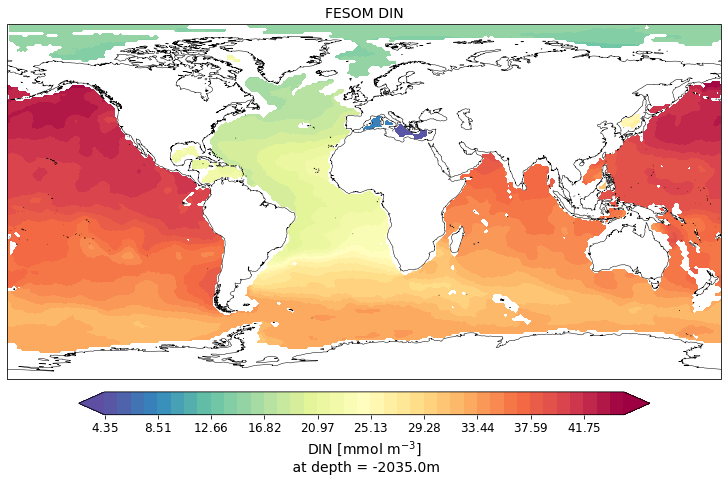

In [12]:
# plot interpolated FESOM data 
if(True):
    pf.plot(mesh, DINfesom[:,i], units=unitfesom + '\n at depth = {0}m'.format(plot_depth),
        mapproj='pc', # robinson projection takes more time!
        titles = labelfesom)
  

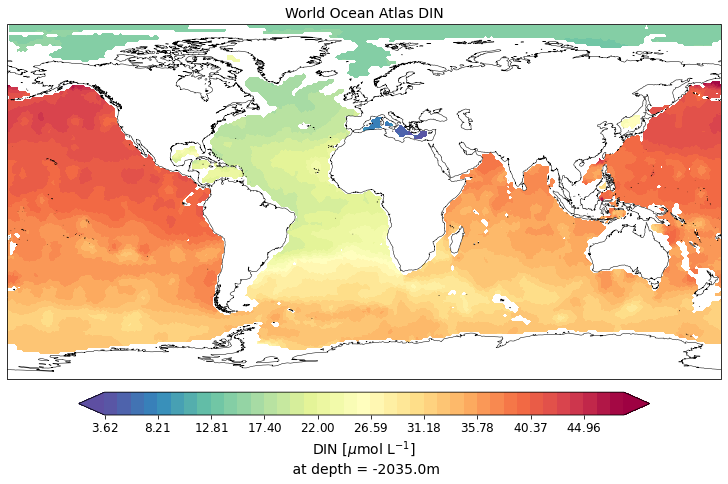

In [13]:
# apply sea mask to WOA as in FESOM ----------------------------------------------------------------------------------
# assumption: there is no ocean where value in FESOM == 0
din_int_ma = np.copy(din_int)
din_int_ma[DINfesom == 0] = 0

if(True):
    # quick check of interpolated WOA data ----------------------------------------------------------------------------------
    pf.plot(mesh,din_int_ma[:,i],
        units=unitwoa + '\n at depth = {0}m'.format(plot_depth), #mapproj='rob',
        titles=labelwoa)    

## Comparison with mean over depth


Plotting DIN as mean over depth
FESOM min = 0.005410965532064438, max = 34.37604522705078
WOA min = 0.0005629408827170412, max = 34.985260415584484


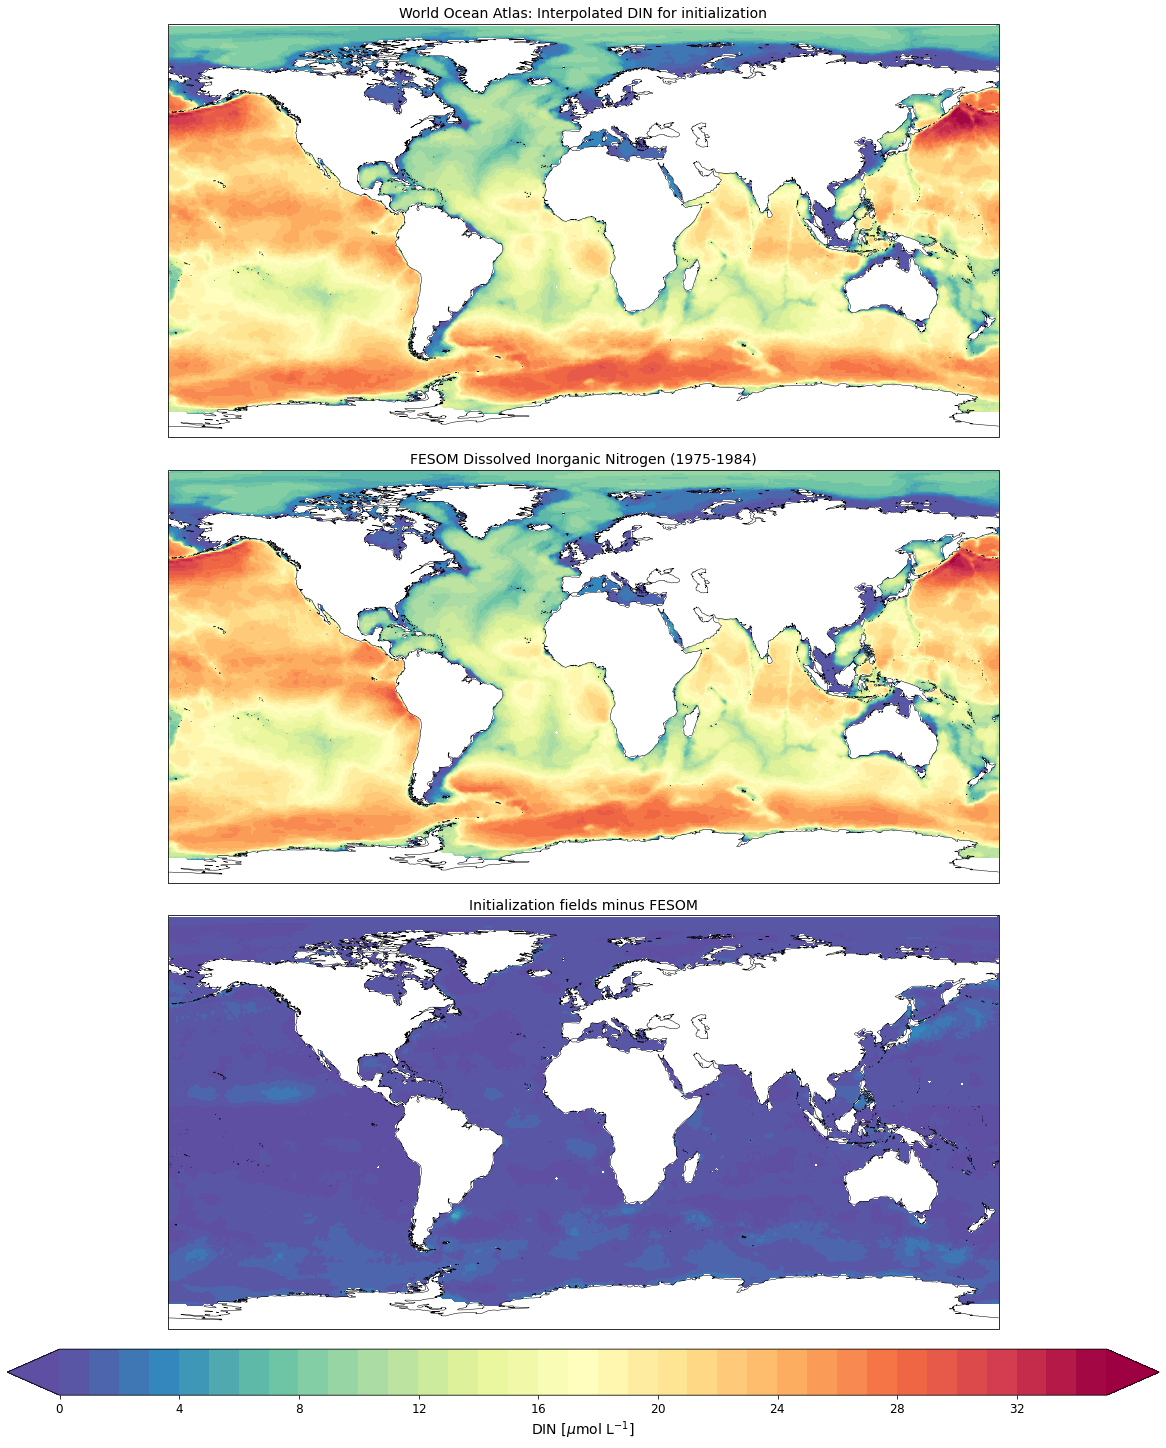

In [14]:
DINfesom_mean = np.mean(DINfesom, axis = 1)
din_int_ma_mean = np.mean(din_int_ma, axis = 1)
#print(np.shape(DINfesom_mean), np.shape(din_int_ma_mean))

if(True):
    print('\nPlotting DIN as mean over depth\nFESOM min = {0}, max = {1}\nWOA min = {2}, max = {3}'.format(
            np.nanmin(DINfesom_mean),np.nanmax(DINfesom_mean),
            np.nanmin(din_int_ma_mean),np.nanmax(din_int_ma_mean)))
    
    pf.plot(mesh, [din_int_ma_mean,DINfesom_mean, din_int_ma_mean-DINfesom_mean], 
            rowscol= (3,1),
            levels = (0,35,36),
            units=unitwoa, 
            mapproj='pc', # robinson projection takes more time!
            titles=['World Ocean Atlas: Interpolated DIN for initialization', 
                    'FESOM Dissolved Inorganic Nitrogen ({0}-{1})'.format(first_year,last_year),
                    'Initialization fields minus FESOM'],
            figsize = (20,20)
           )

## Statistics with mean over depth

In [21]:
#plt_Taylor_norm?

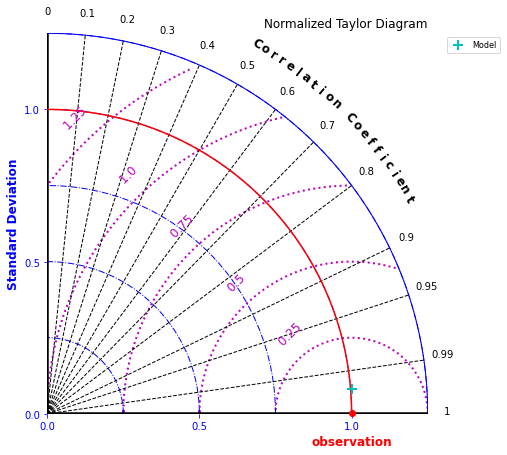

In [15]:
from plot_Taylor_normalized import plt_Taylor_norm

title = 'Taylor Diagram for DIN \n(mean over depth)'

plt_Taylor_norm(din_int_ma_mean,DINfesom_mean, title=title)


Text(1.0, 1.0, 'Taylor Diagram for DIN \n(mean over depth)')

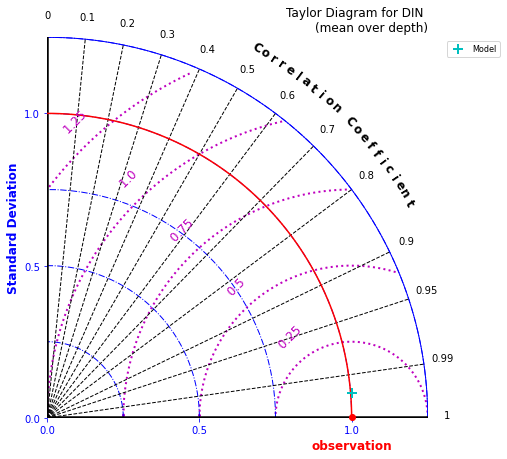

In [16]:
# preparation of datasets
if np.isnan(np.min(din_int_ma_mean)): print('WARNING: The interpolated WOA field contains NaNs at depth')
if np.isnan(np.min(DINfesom_mean)): print('WARNING: The interpolated FESOM field contains NaNs at depth')


# get statistics only from ocean gridpoints (same mask assumption as above)
ind_stat = np.where(DINfesom_mean != 0)

taylor_stats1 = sm.taylor_statistics(din_int_ma_mean[ind_stat],DINfesom_mean[ind_stat])
sdev = np.array([taylor_stats1['sdev'][0]/taylor_stats1['sdev'][0], 
                 taylor_stats1['sdev'][1]/taylor_stats1['sdev'][0]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])

label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

fig = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                      titleOBS = 'observation', markerLabel = label,
                      markerLabelColor = 'c',
                      markerColor = 'c', markerLegend = 'on',
                      #tickRMS = range(0,5,1),
                      tickRMSangle = 135.0,
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      titleRMS = 'off', #tickSTD = range(0,1,2 ),
                      #axismax = 1.0, 
                      colSTD = 'b', styleSTD = '-.',
                      widthSTD = 1.0, titleSTD = 'on',
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                      titleCOR = 'on')
plt.title('Taylor Diagram for DIN \n(mean over depth)', loc='right')    

## Comparison layerwise


Input depth = 0, plotting at depth = -2.5 m
FESOM min = 0.02137712575495243, max = 26.840232849121094
WOA min = 0.0, max = 33.817039489746094

Input depth = 50, plotting at depth = -55.0 m
FESOM min = 0.0, max = 32.55767822265625
WOA min = 0.0, max = 34.77260971069336

Input depth = 200, plotting at depth = -210.0 m
FESOM min = 0.0, max = 42.334251403808594
WOA min = 0.0, max = 42.73545455932617

Input depth = 1000, plotting at depth = -1110.0 m
FESOM min = 0.0, max = 45.96034240722656
WOA min = 0.0, max = 54.11851501464844

Input depth = 2000, plotting at depth = -2035.0 m
FESOM min = 0.0, max = 45.00246047973633
WOA min = 0.0, max = 48.41010665893555

Input depth = 4000, plotting at depth = -4025.0 m
FESOM min = 0.0, max = 39.13381576538086
WOA min = 0.0, max = 40.4844856262207


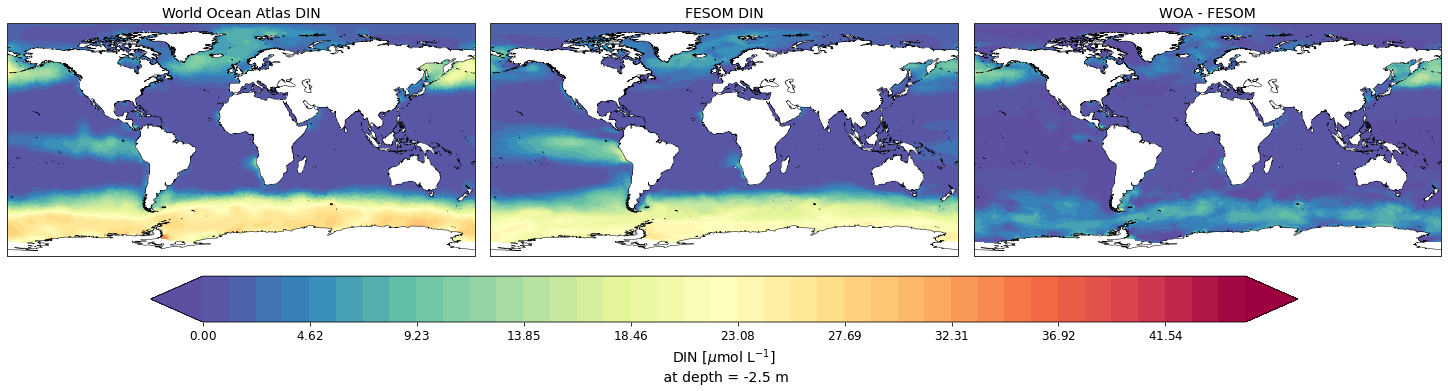

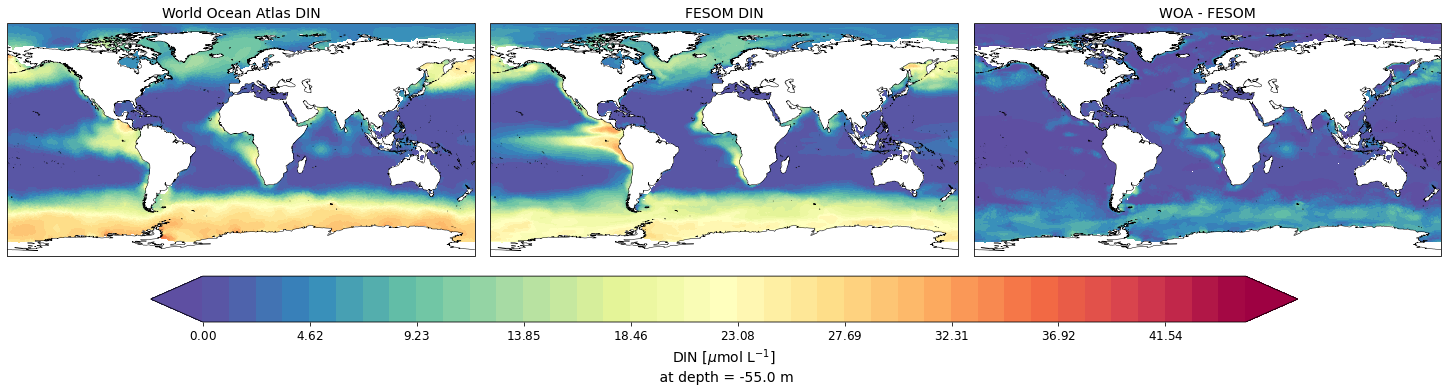

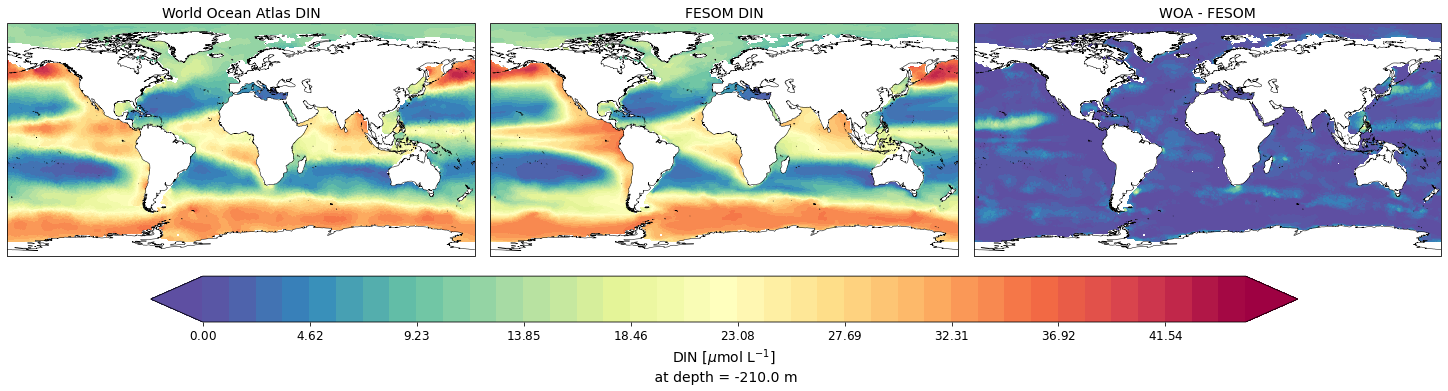

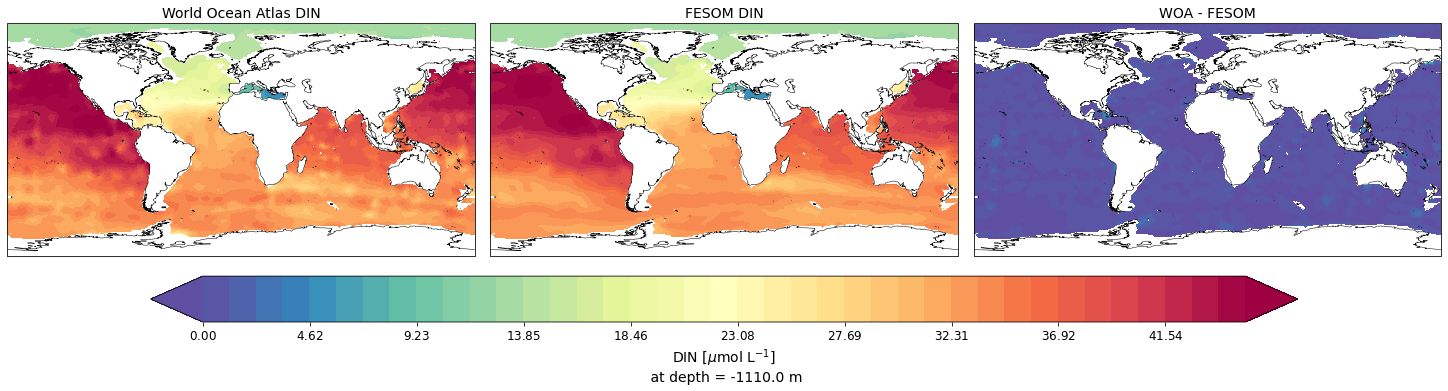

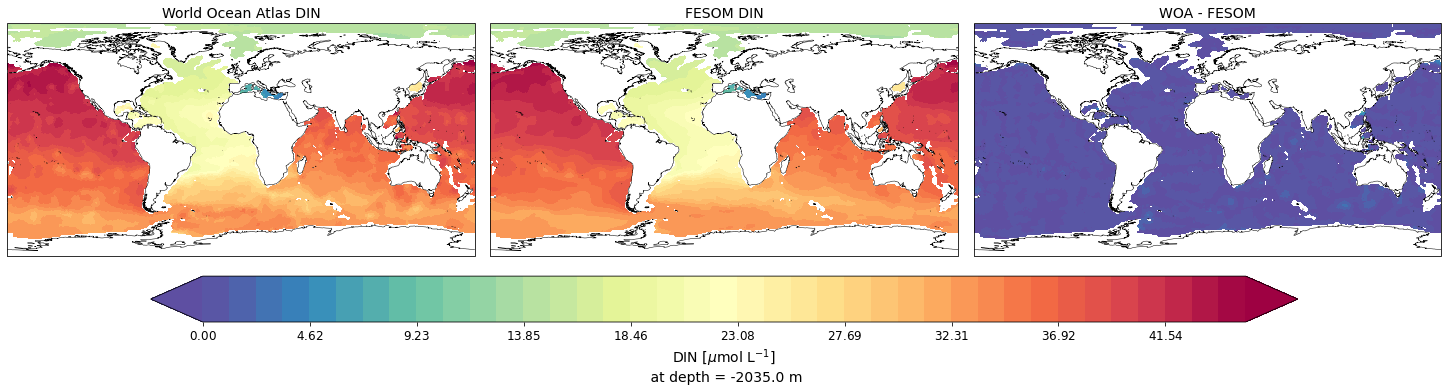

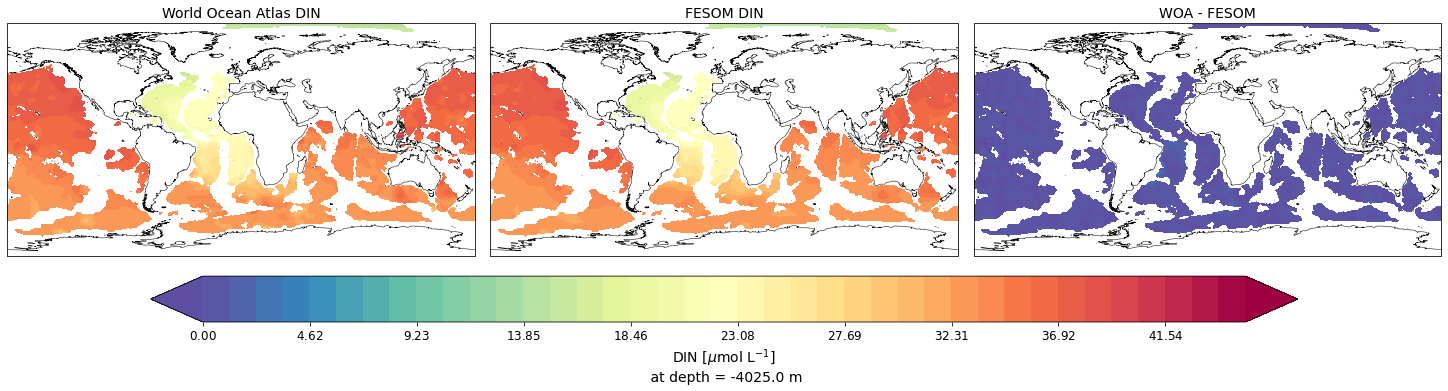

In [17]:
# plot WOA and FESOM ----------------------------------------------------------------------------------
depth_array = (0,50,200,1000,2000,4000)

for d in depth_array:
    # get mesh index closest to desired depth
    i = pf.ind_for_depth(d,mesh) 
    # get midlevel depth
    plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

    if(True):
        print('\nInput depth = {0}, plotting at depth = {1} m\nFESOM min = {2}, max = {3}\nWOA min = {4}, max = {5}'.format(
            d,plot_depth,
            np.nanmin(DINfesom[:,i]),np.nanmax(DINfesom[:,i]),
            np.nanmin(din_int_ma[:,i]),np.nanmax(din_int_ma[:,i])))
    
    pf.plot(mesh, [din_int_ma[:,i],DINfesom[:,i], din_int_ma[:,i]-DINfesom[:,i]], 
            rowscol= (1,3),
            levels = (0,45,40),
            units=unitwoa + '\n at depth = {0} m'.format(plot_depth), 
            mapproj='pc', # robinson projection takes more time!
            titles=[labelwoa, labelfesom, 'WOA - FESOM'],figsize = (20,20)
           )

## Statistics layerwise

In [18]:
#sm.taylor_statistics?

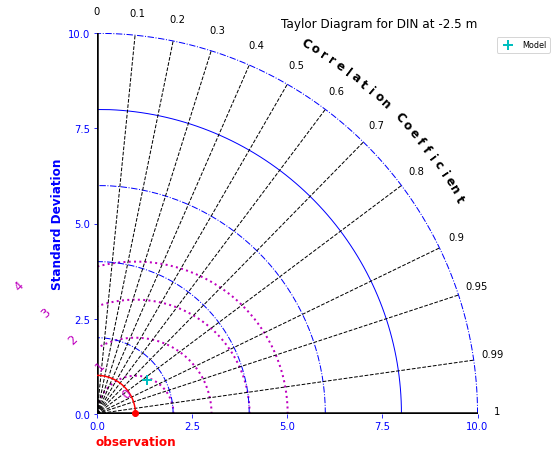

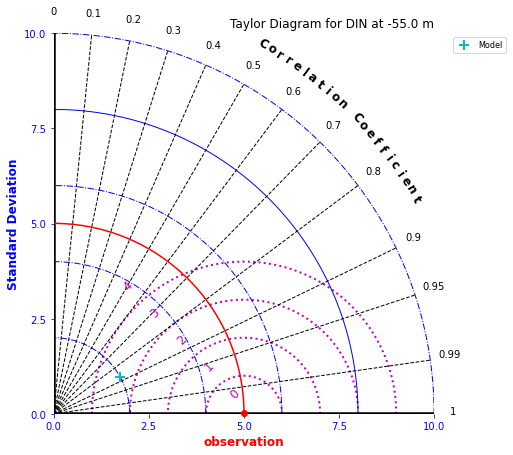

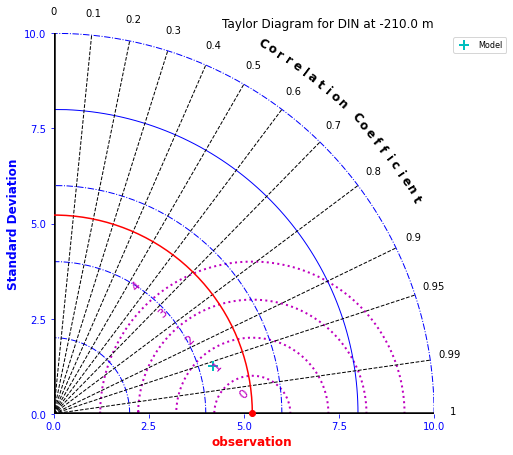

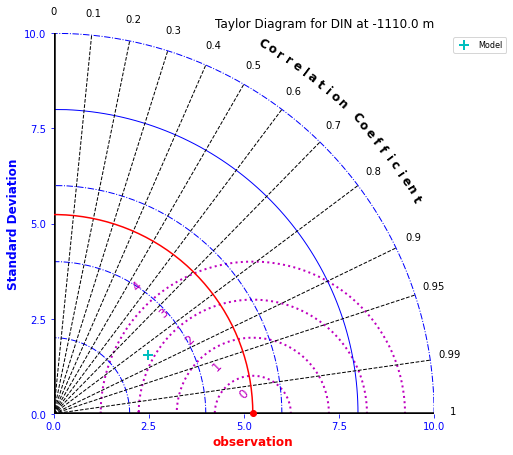

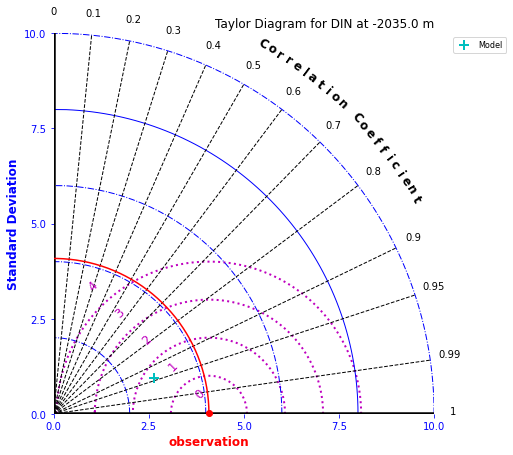

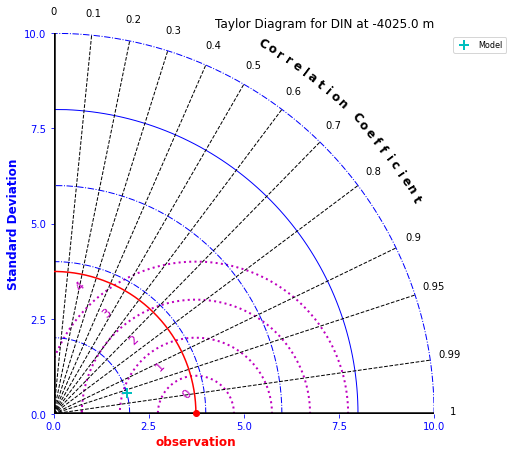

In [19]:
# preparation of datasets
if np.isnan(np.min(din_int)): print('WARNING: The interpolated WOA field contains NaNs at depth')
if np.isnan(np.min(DINfesom)): print('WARNING: The interpolated FESOM field contains NaNs at depth')


for d in depth_array:
    # get mesh index closest to desired depth
    i = pf.ind_for_depth(d,mesh) 
    # get midlevel depth
    plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

    # get statistics only from ocean gridpoints (same mask assumption as above)
    ind_stat = np.where(DINfesom[i,:] != 0)

    taylor_stats1 = sm.taylor_statistics(din_int[i,ind_stat],DINfesom[i,ind_stat])
    sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
    crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
    ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])
    
    label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

    fig = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
    sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                          titleOBS = 'observation', markerLabel = label,
                          markerLabelColor = 'c',
                          markerColor = 'c', markerLegend = 'on',
                          tickRMS = range(0,5,1), tickRMSangle = 135.0,
                          colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                          titleRMS = 'off', tickSTD = range(0,10,2 ),
                          axismax = 10.0, 
                          colSTD = 'b', styleSTD = '-.',
                          widthSTD = 1.0, titleSTD = 'on',
                          colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                          titleCOR = 'on')
    plt.title('Taylor Diagram for DIN at {0} m'.format(plot_depth), loc='right')

#### now export...

In [20]:
if(export_html):
    %autosave 2
    import time
    time.sleep(15)
    !jupyter nbconvert MZ_DIN_WOA_detailed_comparison_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 